# Importing the Libraries

Installing the Library in the system

In [2]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3195801 sha256=c56680b8133bfbc572b2b4de47d8d4399fcd6cddfb412f40e271070e5b614855
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

pd.options.display.max_columns=None
#pd.set_option('display.max_colwidth', None)

import warnings; warnings.simplefilter('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Now we have installed the libraries and are ready for our model creation. Let us first see the simplest approach- i.e. The Simple Recommender

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> **Reading the Larger Dataset**

In [5]:
meta = pd. read_csv('/content/drive/MyDrive/Colab Notebooks/movies_metadata.csv')
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


> **Let's identify the total number of null values in the data:**

In [6]:
meta.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

**Observation** Okay, so the dataset has sufficient number of null values- and it will be better if we can clean them. Also, we observe some of the columns have a list of dictionary structure- but it isn't a very easy format to read. So let's just clean it up to create an ordinary list.

> **Cleaning the Dataset**

In [7]:
meta['genres'] = meta['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
meta['production_companies']= meta['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
meta['production_countries'] = meta['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
meta['spoken_languages'] = meta['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
meta['year'] = pd.to_datetime(meta['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

> **Let's take a final look at the data before moving to our next steps**

In [8]:
meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,81.0,[English],Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0.0,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156.0,127.0,[English],Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,76578911.0,106.0,[English],Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


In [9]:
meta['original_language'].drop_duplicates().shape[0]

93

In [10]:
lang_df = pd.DataFrame(meta['original_language'].value_counts())
lang_df['language'] = lang_df.index
lang_df.columns = ['number', 'language']
lang_df.head()

,number,language
en,32269,en
fr,2438,fr
it,1529,it
ja,1350,ja
de,1080,de


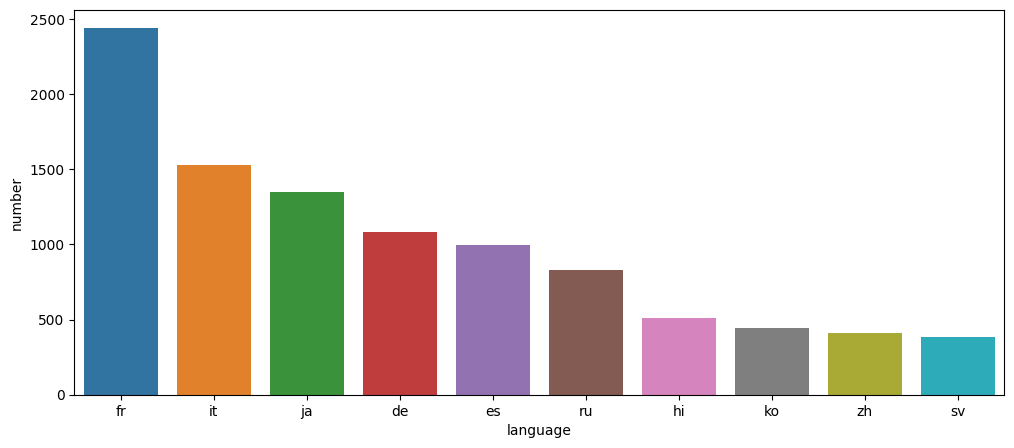

In [11]:
plt.figure(figsize=(12,5))
sns.barplot(x='language', y='number', data=lang_df.iloc[1:11])
plt.show()

In [12]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [13]:
meta['popularity'] = meta['popularity'].apply(clean_numeric).astype('float')
meta['vote_count'] = meta['vote_count'].apply(clean_numeric).astype('float')
meta['vote_average'] = meta['vote_average'].apply(clean_numeric).astype('float')

In [14]:
meta['popularity'].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

In [15]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']


In [16]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan


In [17]:
meta['day'] = meta['release_date'].apply(get_day)
meta['month'] = meta['release_date'].apply(get_month)

<Axes: title={'center': 'Number of Movies released in a particular month.'}, xlabel='month', ylabel='count'>

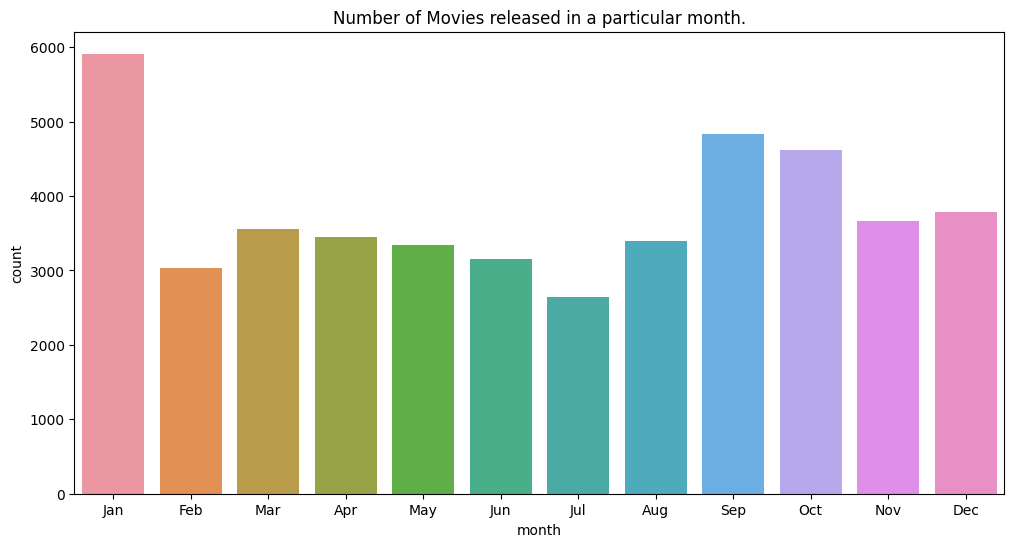

In [18]:
#With these features in hand, let us now check the most popular and most successful months and days.

plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular month.")
sns.countplot(x='month', data=meta, order=month_order)

It appears that January is the most popular month when it comes to movie releases. In Hollywood circles, this is also known as the the dump month when sub par movies are released by the dozen.




In which months do bockbuster movies tend to release? To answer this question, we will consider all movies that have made in excess of 100 million dollars and calculate the average gross for each month.


<Axes: title={'center': 'Average Gross by the Month for Blockbuster Movies'}, xlabel='month', ylabel='revenue'>

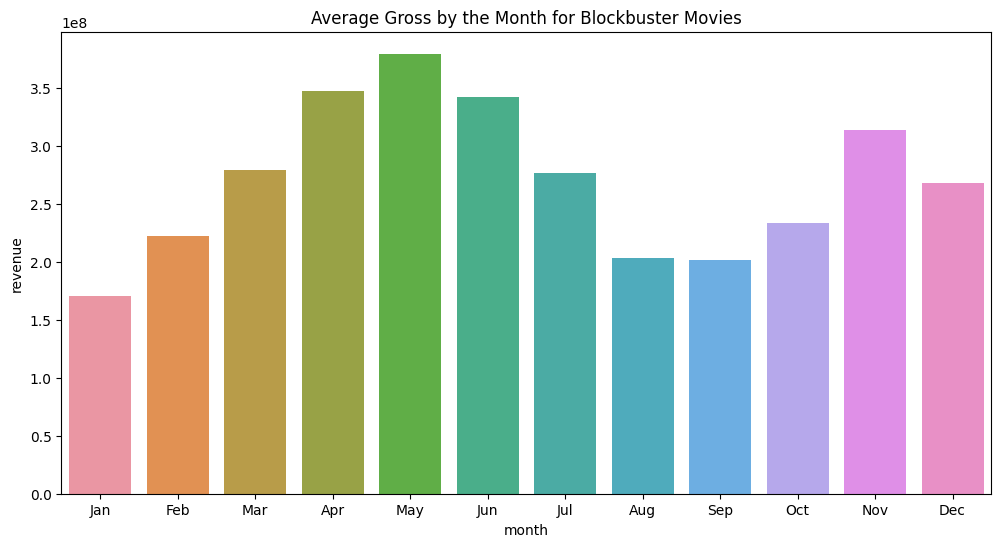

In [19]:
month_mean = pd.DataFrame(meta[meta['revenue'] > 1e8].groupby('month')['revenue'].mean())
month_mean['month'] = month_mean.index
plt.figure(figsize=(12,6))
plt.title("Average Gross by the Month for Blockbuster Movies")
sns.barplot(x='month', y='revenue', data=month_mean, order=month_order)

Number of Movies by the year
The Dataset of 45,000 movies available to us does not represent the entire corpus of movies released since the inception of cinema. However, it is reasomnable to assume that it does include almost every major film released in Hollywood as well as other major film industries across the world (such as Bollywood in India). With this assumption in mind, let us take a look at the number of movies produced by the year.

<Axes: xlabel='year'>

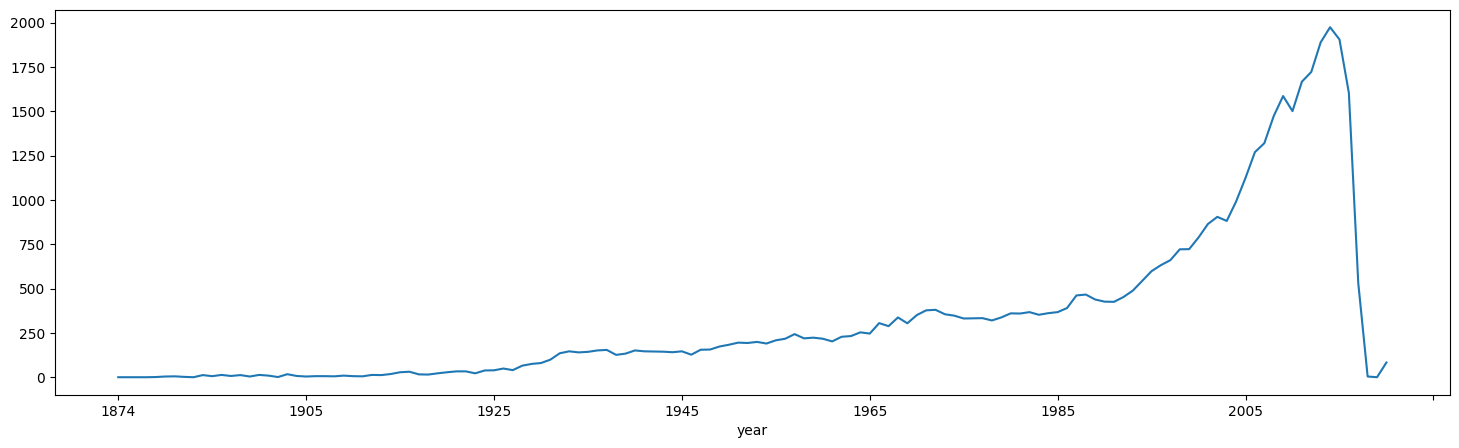

In [20]:
year_count = meta.groupby('year')['title'].count()
plt.figure(figsize=(18,5))
year_count.plot()

Finally, in this section, let us construct a heatmap to indicate movie releases by month and year for all movies released in this century. This will give us a good idea of the hot and cold months for movie buffs.


In [21]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

<Axes: xlabel='year', ylabel='month'>

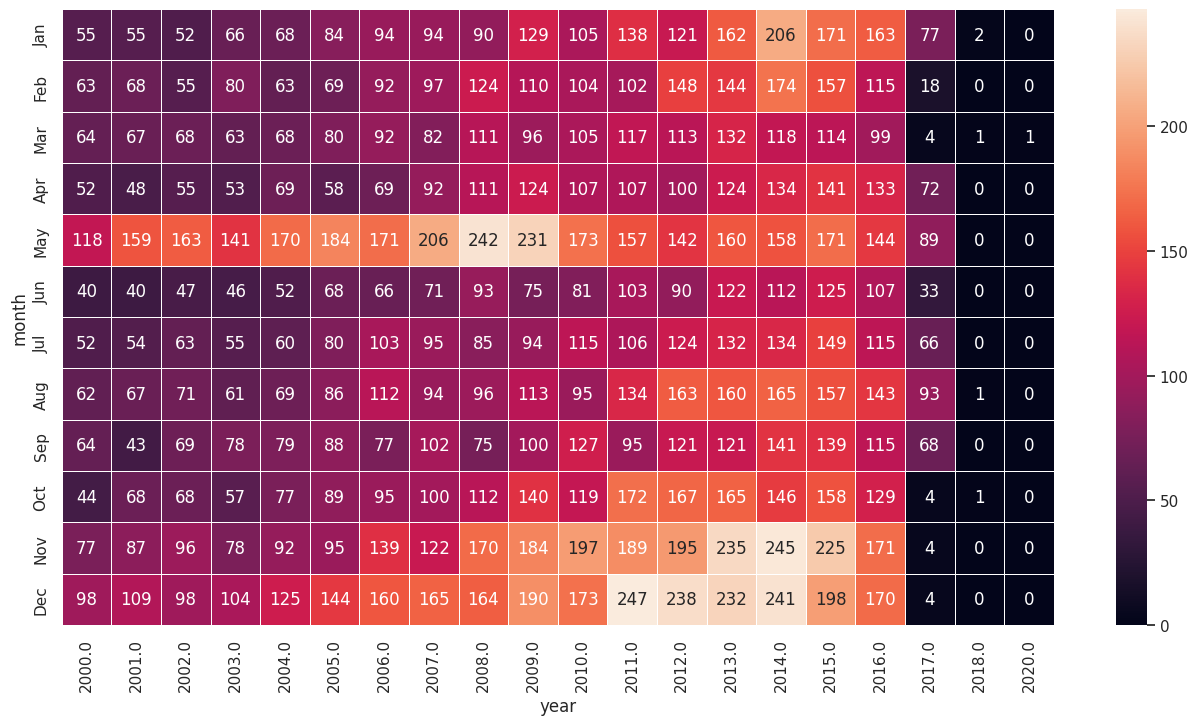

In [22]:
df_21 = meta.copy()
df_21['year'] = df_21[df_21['year'] != 'NaT']['year'].astype(int)
df_21 = df_21[df_21['year'] >=2000]
hmap_21 = pd.pivot_table(data=df_21, index='month', columns='year', aggfunc='count', values='title')
hmap_21 = hmap_21.fillna(0)
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(hmap_21, annot=True, linewidths=.5, ax=ax, fmt='n', yticklabels=month_order)

Next, I'd like to see the average lengths of movies through time, right from the 1890s to the 2017s. It would be interesting to see the trends in what filmmakers adjudged would be the appropriate length of a movie at that time.

<Axes: xlabel='runtime', ylabel='Density'>

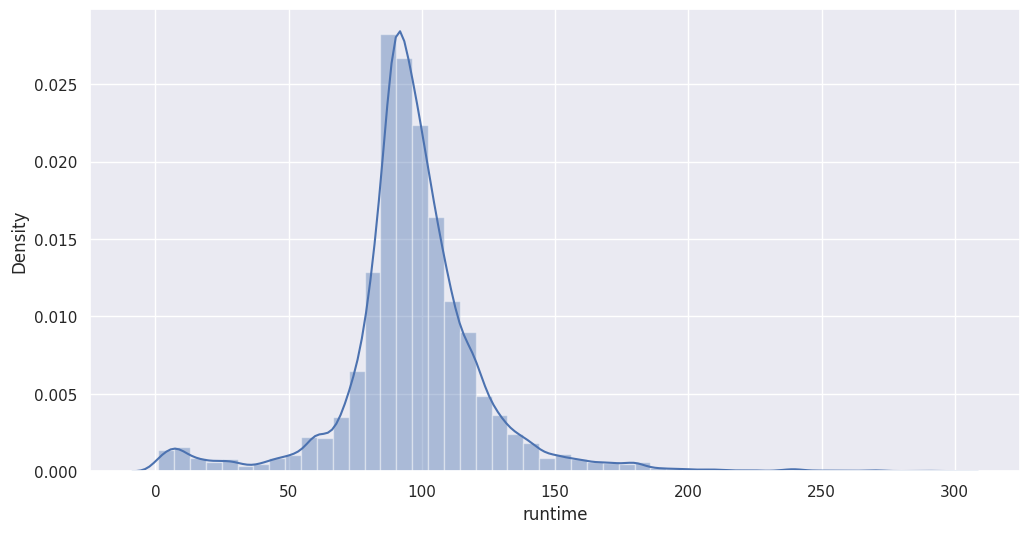

In [23]:
meta['runtime'] = meta['runtime'].astype('float')

#We are aware that most movies are less than 5 hours (or 300 minutes) long. Let us plot a distribution of these mainstream movies.

plt.figure(figsize=(12,6))
sns.distplot(meta[(meta['runtime'] < 300) & (meta['runtime'] > 0)]['runtime'])

# The Simple Popularity Based Recommender

The Simple Recommender offers generalized recommnendations to every user based on movie popularity and (sometimes) genre. The basic idea behind this recommender is that movies that are more popular and more critically acclaimed will have a higher probability of being liked by the average audience. This model does not give personalized recommendations based on the user.

We will use the IMDB Ratings to come up with our Top Movies Chart. I will use IMDB's weighted rating formula to construct my chart. Mathematically, it is represented as follows:

                            Weighted Rank (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
where,

                             R = average for the movie (mean) = (Rating)
                             v = number of votes for the movie = (votes)
                             m = minimum votes required to be listed in the Top 250 
                             C = the mean vote across the whole report 
                             
The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 96% of the movies in the list.

I will build our overall Top 250 Chart and will define a function to build charts for a particular genre. Let's begin!

In [24]:
vote_counts = meta[meta['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = meta[meta['vote_average'].notnull()]['vote_average'].astype('int')

In [25]:
C = vote_averages.mean()
print('The Mean value of the voting averages= ',C)
m = vote_counts.quantile(0.96)
print('The minimum vote count for a movie to consider= ',m)

The Mean value of the voting averages=  5.244896612406511
The minimum vote count for a movie to consider=  576.6399999999994


> **Creating the qualified database- upon whom we shall perfrom the next estimations**

In [26]:
qualified = meta[(meta['vote_count'] >= m) & (meta['vote_count'].notnull()) & (meta['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
print('The structure of the qualified database is= ',qualified.shape)

The structure of the qualified database is=  (1819, 6)


Therefore, to qualify to be considered for the chart, a movie has to have at least 576.63 votes on TMDB. We also see that the average rating for a movie on TMDB is 5.244 on a scale of 10. Only 1899 Movies qualify to be on our chart.

In [27]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [28]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False).head(250)

**Top Movies**



In [29]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.891568
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.876324
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.864948
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.845075
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.832214
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.828186
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.822186
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.819520
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.817885
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.806672


**Observations:** We see that three Christopher Nolan Films, Inception, The Dark Knight and Interstellar occur at the very top of our chart. The chart also indicates a strong bias of TMDB Users towards particular genres and directors.

Let us now construct our function that builds charts for particular genres. For this, we will use relax our default conditions to the 90th percentile instead of 96.

> **Pivoting down the entire dataset based on genres**

In [30]:
s = meta.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = meta.drop('genres', axis=1).join(s)
gen_md.head(8)

,adult,belongs_to_collection,budget,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year,day,month,genre
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,81.0,[English],Released,NaN,Toy Story,False,7.7,5415.0,1995,NaN,Oct,Animation
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,81.0,[English],Released,NaN,Toy Story,False,7.7,5415.0,1995,NaN,Oct,Comedy
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,81.0,[English],Released,NaN,Toy Story,False,7.7,5415.0,1995,NaN,Oct,Family
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,NaN,Dec,Adventure
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,NaN,Dec,Fantasy
1,False,NaN,65000000,NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249.0,104.0,"[English, Français]",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995,NaN,Dec,Family
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0.0,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,NaN,Dec,Romance
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0.0,101.0,[English],Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995,NaN,Dec,Comedy


So now, we will create a function that returns us the list of top movies for a genre!

In [31]:
def build_chart(genre, percentile=0.90):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

Let us see our method in action by displaying the Top 15 Horror Movies (Horror almost didn't feature at all in our Generic Top Chart despite being one of the most popular movie genres).

**Top Horror Movies**



In [32]:
build_chart('Horror').head(15)

,title,year,vote_count,vote_average,popularity,wr
1213,The Shining,1980,3890,8,19.611589,7.837897
1176,Psycho,1960,2405,8,36.826309,7.745768
1171,Alien,1979,4564,7,23.377420,6.904360
41492,Split,2016,4461,7,28.920839,6.902250
14236,Zombieland,2009,3655,7,11.063029,6.881855
1158,Aliens,1986,3282,7,21.761179,6.869227
21276,The Conjuring,2013,3169,7,14.901690,6.864851
42169,Get Out,2017,2978,7,36.894806,6.856749
1338,Jaws,1975,2628,7,19.726114,6.839069
8147,Shaun of the Dead,2004,2479,7,14.902948,6.830145


Lets look for some recommendations of the Romantic Genre

**Top Romantic Movies**


In [33]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.271289
351,Forrest Gump,1994,8147,8,48.307194,7.947552
876,Vertigo,1958,1162,8,18.208220,7.672104
40251,Your Name.,2016,1030,8,34.461252,7.635975
883,Some Like It Hot,1959,835,8,11.845107,7.565203
1132,Cinema Paradiso,1988,834,8,14.177005,7.564769
19901,Paperman,2012,734,8,7.198633,7.516517
37863,Sing Street,2016,669,8,10.672862,7.478971
882,The Apartment,1960,498,8,11.994281,7.345193
38718,The Handmaiden,2016,453,8,16.727405,7.297743


**Observations:** Well no wonders, the movie "Dilwale Dulhaniya Le Jayenge" starring Shah Rukh Khan- the King of Romance would top this list!

# Content Based Recommender
Since we will be using movie metadata (or content) to build this engine, this also known as Content Based Filtering.

We will build two Content Based Recommenders based on:

1. Movie Overviews and Taglines
2. Movie Cast, Crew, Keywords and Genre

Also, we will be using a subset of all the movies available to us due to limiting computing power available to me.

In [34]:
links_small = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [35]:
links_small.head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int64

> Deleting the unwanted input rows. These rows required special treatments of processing, and also protrayed lower weighted scores- hence would not have been a part of the recommendations- So we can safely remove them

In [36]:
meta = meta.drop([19730, 29503, 35587])

In [37]:
meta['id'] = meta['id'].astype('int')

In [38]:
smd = meta[meta['id'].isin(links_small)]
smd.shape

(9099, 27)

We have 9099 movies avaiable in our small movies metadata dataset which is 5 times smaller than our original dataset of 45000 movies.

**Movie Description Based Recommender**


In [39]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

**We shall be using Tfidfvectorizer for this step.**

With Tfidftransformer you will systematically compute word counts using CountVectorizer and then compute the Inverse Document Frequency (IDF) values and only then compute the Tf-idf scores. However with Tfidfvectorizer on the contrary, you will do all three steps at once. Under the hood, it computes the word counts, IDF values, and Tf-idf scores all using the same dataset.


In [40]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

Let's look at the shape of the TF-IDF Vectorizer

In [41]:
tfidf_matrix.shape

(9099, 268124)

**Cosine Similarity**
I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Mathematically, it is defined as follows:

cosine(x,y)=(x.y)/(||x||.||y||)

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [42]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

We now have a pairwise cosine similarity matrix for all the movies in our dataset. The next step is to write a function that returns the 20 most similar movies based on the cosine similarity score.

In [43]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [44]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

We're all set. Let us now try and get the top recommendations for a few movies and see how good the recommendations are. We shall take a look into the Indian Movie- **3 Idiots**. 
So before checking the recommendations- let us check what is the **description of this movie?**


In [45]:
movie='3 Idiots'
print("Description of the Movie: ", movie)
print('---------------------------------------------------------------------')
print(smd[smd['title']==movie]['overview'])

Description of the Movie:  3 Idiots
---------------------------------------------------------------------
7422    In the tradition of “Ferris Bueller’s Day Off”...
Name: overview, dtype: object


**Observations:** Okay lets jot down a few points that we need to look for in the recommendations.
1. Firstly “Ferris Bueller’s Day Off”- so we get an idea that this movie might be a recommendation.
2. A rebellious prankster in the college and his story with the lives of his two newfound best friends.
3. The Dean of the college is uptight and heartless- and his name is "Virus"
4. The Dean has a beautiful daughter- who shall be the love interest of the protagonist

So gathering up the points, lets just check our recommendations!

In [46]:
get_recommendations('3 Idiots').head(20)

2336                             Ferris Bueller's Day Off
8161                                  Student of the Year
262                                              Outbreak
2658                                  The Next Best Thing
4378    Come Back to the 5 & Dime, Jimmy Dean, Jimmy Dean
1861                                   Enemy of the State
3098                                          Bring It On
7866                                            Contagion
4543                                    What a Girl Wants
5373                                              College
149                                               Hackers
3875                                            The Party
5462                                      Our Hospitality
5466                                            Overboard
3496                                             Suspiria
2882                                                Loser
308                                 The Baby-Sitters Club
1937          

**Observation:** Cool! The first movie predicted is- "Ferris Bueller's Day Off", which is present in the description. 

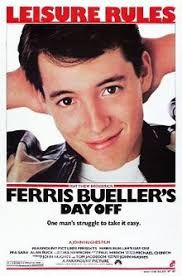

Indeed nice choice. We also see college oriented movies like Student of the year, College and Hackers.

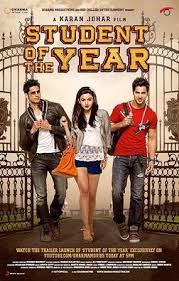

The thing which I was amused with most is since the name of the Dean was "Virus"- movies like Outbreak and Contagion have been predicted.

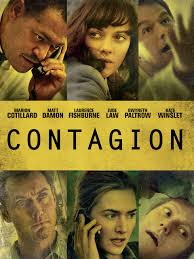

Now a point that surprises me is why Lion King? Is it because of the two best friends- maybe an hint to Timon and Pumba! Woah! That was an interesting one

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQeUwVrHEpGQHWgitOSt3gZiNIW4g5RidibGg&usqp=CAU)

So indeed we have been able to go for nice predictions!!! I already love it!






> Now let us look into another movie- another classic- **The Dark Knight** - but before checking, we shall look into the description here as well
> 
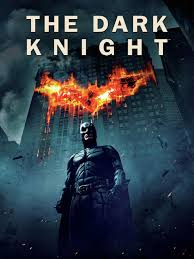

In [47]:
movie='The Dark Knight'
print("Description of the Movie: ", movie)
print('---------------------------------------------------------------------')
print(smd[smd['title']==movie]['overview'])

Description of the Movie:  The Dark Knight
---------------------------------------------------------------------
6900    Batman raises the stakes in his war on crime. ...
Name: overview, dtype: object


**Observation** Well, as we have all seen- the movie is mainly the story of Batman, and how he fights criminals to protect the city of Gotham. Another very important part of this movie will be the main antagonist- the Joker. Lets take a look at the recommendations now!

In [48]:
get_recommendations('The Dark Knight').head(20)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
6144                              Batman Begins
7933         Sherlock Holmes: A Game of Shadows
5511                            To End All Wars
4489                                      Q & A
7344                        Law Abiding Citizen
7242                  The File on Thelma Jordon
3537                               Criminal Law
2893                              Flying Tigers
1135                   Night Falls on Manhattan
8680                          The Young Savages
Name: title, dtype: object

**Observations:** We see that for The Dark Knight, our system is able to identify it as a Batman film and subsequently recommend other Batman films as its top recommendations.

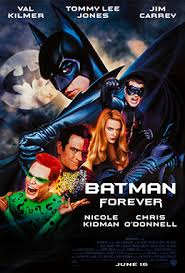

However based on the mention of criminal organizations in the description- there are also some movies recommended that were on the theme of Police and Crimes- To End all Wars, Q&A etc

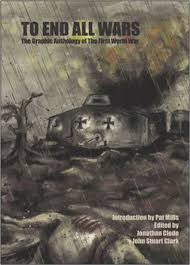

> But unfortunately, that is all this system can do at the moment. This is not of much use to most people as it doesn't take into considerations very important features such as cast, crew, director and genre, which determine the rating and the popularity of a movie. Someone who liked The Dark Knight probably likes it more because of Nolan and would hate Batman Forever and every other substandard movie in the Batman Franchise.
> 
> Therefore, we are going to use much more suggestive metadata than Overview and Tagline. In the next subsection, we will build a more sophisticated recommender that takes genre, keywords, cast and crew into consideration.

# Metadata Based Recommender
To build our standard metadata based content recommender, we will need to merge our current dataset with the crew and the keyword datasets. Let us prepare this data as our first step.

In [49]:
credits = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/credits.csv')
keywords = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/keywords.csv')

In [50]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [51]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [52]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
meta['id'] = meta['id'].astype('int')
meta.shape

(45463, 27)

In [53]:
meta = meta.merge(credits, on='id')
meta = meta.merge(keywords, on='id')

Let's look at the shape of the smaller metadata

In [54]:
smd = meta[meta['id'].isin(links_small)]
smd.shape

(9219, 30)

We now have our cast, crew, genres and credits, all in one dataframe. Let us wrangle this a little more using the following intuitions:

1. **Crew:** From the crew, we will only pick the director as our feature since the others don't contribute that much to the feel of the movie.The director's touch was the most important parameter as we have seen in the above segment.

2. **Cast:** Choosing Cast is a little more tricky. Lesser known actors and minor roles do not really affect people's opinion of a movie. Therefore, we must only select the major characters and their respective actors. Arbitrarily we will choose the top 4 actors that appear in the credits list.

In [55]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [56]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [57]:
smd['director'] = smd['crew'].apply(get_director)

In [58]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:4] if len(x) >=4 else x)


In [59]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

Our approach to building the recommender is going to be extremely hacky. What we plan on doing is creating a metadata dump for every movie which consists of genres, director, main actors and keywords. Then we use a similar apporach as above-i.e. Count Vectorizer to create our count matrix as we did in the Description Recommender.
The remaining steps would be similar to what we did earlier: we calculate the cosine similarities and return movies that are most similar.

These are steps that we need to follow in the preparation of genres and credits data:

1. Strip Spaces and Convert to Lowercase from all our features. This way, our engine will not confuse between George Clooney and George Hamilton.
2. Mention Director 3 times to give it more weight relative to the entire cast

In [60]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [61]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x,x])

Keywords

We will do a small amount of pre-processing of our keywords before putting them to any use. As a first step, we calculate the frequenct counts of every keyword that appears in the dataset.

In [62]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [63]:
s = s.value_counts()
s[:10]

independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
violence                264
love                    222
musical                 219
sex                     219
suspense                212
Name: keyword, dtype: int64

Keywords occur in frequencies ranging from 1 to 610. We do not have any use for keywords that occur only once. Therefore, these can be safely removed.

In [64]:
s = s[s > 1]

Finally, we will convert every word to its stem so that words such as Sportingly and Sport are considered the same.

In [65]:
stemmer = SnowballStemmer('english')
stemmer.stem('sportingly')

'sport'

In [66]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [67]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [68]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

Applying the same Count Vectorizer and Cosine Similarity as mentioned:

In [69]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [70]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [71]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

We will reuse the get_recommendations function that we had written earlier. Since our cosine similarity scores have changed, we expect it to give us different (and probably better) results. Let us check for The Dark Knight again and see what recommendations I get this time around.

In [72]:
get_recommendations('The Dark Knight').head(15)

8031                 The Dark Knight Rises
6218                         Batman Begins
6623                          The Prestige
2085                             Following
7648                             Inception
4145                              Insomnia
3381                               Memento
8613                          Interstellar
7659            Batman: Under the Red Hood
1134                        Batman Returns
5943                              Thursday
8927               Kidnapping Mr. Heineken
1260                        Batman & Robin
9024    Batman v Superman: Dawn of Justice
9162                     London Has Fallen
Name: title, dtype: object

I am much more satisfied with the results I get this time around. The recommendations seem to have recognized other Christopher Nolan movies (due to the high weightage given to director) and put them as top recommendations.

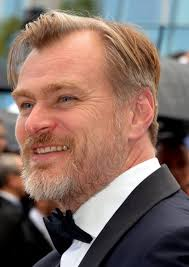

Also adding the cast we got other movies of the same actors into the recommendation list- The Prestige (Cristian Bale), Thursday (Aaron Eckhart or better known as Harvey Dent), Interstellar (Michael Caine) etc. The movies where the actors have collaborated with Nolan earned the highest ranks in the recommended list. That was quite amazing!

![](https://media.gettyimages.com/photos/michael-caine-christian-bale-maggie-gyllenhaal-and-aaron-eckhart-at-picture-id834728940)

We can of course experiment on this engine by trying out different weights for our features (directors, actors, genres), limiting the number of keywords that can be used in the soup, weighing genres based on their frequency, only showing movies with the same languages, etc.

Let us also get recommendations for another movie.

I was really fascinated by the movie **"Mrs. Doubtfire"** when I was a Kid- and it made me a huge fan of Robin Williams. Lets try to see what would be the recommendations for a user interested in the movie!

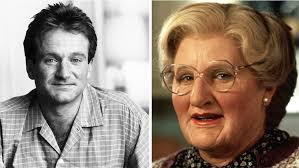

In [73]:
get_recommendations('Mrs. Doubtfire').head(15)

164                                           Nine Months
2553                                     Bicentennial Man
519                                            Home Alone
2388                       Home Alone 2: Lost in New York
1958                                              Stepmom
7538    Percy Jackson & the Olympians: The Lightning T...
8996                                               Pixels
7377                              I Love You, Beth Cooper
1708                            Adventures in Babysitting
3840             Harry Potter and the Philosopher's Stone
4366              Harry Potter and the Chamber of Secrets
6357                                                 Rent
2833                                           Parenthood
4378                                            Houseboat
6057                                           Fat Albert
Name: title, dtype: object

**Observations** Mrs. Doubtfire, Home Alone Series and the first few movies of Harry Potter were directed by the same person-**Chris Columbus**! 

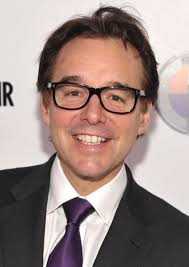

This model creation really improved my knowledge on the world of movies! :)

Also based on the actors- Nine Months and Bicentennial Man had Robin Williams in the Lead, while for Percy Jackson & the Olympians: The Lightning Thief, we had Pierce Brosnan in the Lead, and both have worked together for Mrs. Doubtfire!  

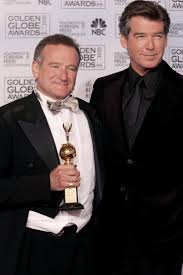

So in short, we have been succesful in our target of recommending the movies based on the cast and crew- with a special importance to the director.

But,one thing that we notice about our recommendation system is that it recommends movies regardless of ratings and popularity.

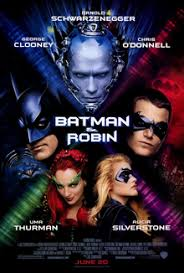

It is true that Batman and Robin has a lot of similar characters as compared to The Dark Knight but it was a terrible movie that shouldn't be recommended to anyone.

Therefore, we will add a mechanism to remove bad movies and return movies which are popular and have had a good critical response.

I will take the top 15 movies based on similarity scores and calculate the vote of the 50th percentile movie. Then, using this as the value of  m , we will calculate the weighted rating of each movie using IMDB's formula like we did in the Simple Recommender section.


In [74]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.50)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [75]:
improved_recommendations('The Dark Knight')

,title,vote_count,vote_average,year,wr
7648,Inception,14075,8,2010,7.891568
8613,Interstellar,11187,8,2014,7.864948
6623,The Prestige,4510,8,2006,7.687671
3381,Memento,4168,8,2000,7.665158
8031,The Dark Knight Rises,9263,7,2012,6.897144
6218,Batman Begins,7511,7,2005,6.874863
1134,Batman Returns,1706,6,1992,5.809246
4145,Insomnia,1181,6,2002,5.752268
132,Batman Forever,1529,5,1995,5.067066
9162,London Has Fallen,1656,5,2016,5.063251


Fortunately, Batman and Robin does not appear from our recommendation list. So we can infer that we have been succesfully able to filter only the movies that have a good rating, as well as match our desired outcome as seen above

In [76]:
improved_recommendations('Mrs. Doubtfire')

,title,vote_count,vote_average,year,wr
3840,Harry Potter and the Philosopher's Stone,7188,7,2001,6.869657
4366,Harry Potter and the Chamber of Secrets,5966,7,2002,6.845313
519,Home Alone,2487,7,1990,6.669653
2388,Home Alone 2: Lost in New York,2459,6,1992,5.856563
7538,Percy Jackson & the Olympians: The Lightning T...,2079,6,2010,5.836038
2553,Bicentennial Man,998,6,1999,5.723478
1958,Stepmom,286,6,1998,5.495244
837,Homeward Bound: The Incredible Journey,218,6,1993,5.452050
2833,Parenthood,177,6,1989,5.422240
1708,Adventures in Babysitting,169,6,1987,5.416041


**Observation** Based on rating parameters, Harry Potter movies tops this list now. Indeed they were loved and appreciated by the audience.

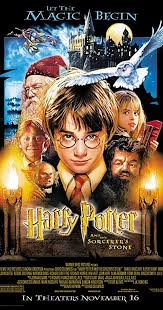



# Collaborative Filtering Application

Uptill now the recommender that we have created, our content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who s/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to Movie Watchers. Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

We shall not be implementing Collaborative Filtering from scratch. Instead, I will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.


In [77]:
reader = Reader()
ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [78]:
rating_counts = pd.DataFrame(ratings['rating'].value_counts()).reset_index()
rating_counts.columns = ['Labels', 'Ratings']
rating_counts

,Labels,Ratings
0,4.0,28750
1,3.0,20064
2,5.0,15095
3,3.5,10538
4,4.5,7723
5,2.0,7271
6,2.5,4449
7,1.0,3326
8,1.5,1687
9,0.5,1101


<Axes: xlabel='rating', ylabel='Density'>

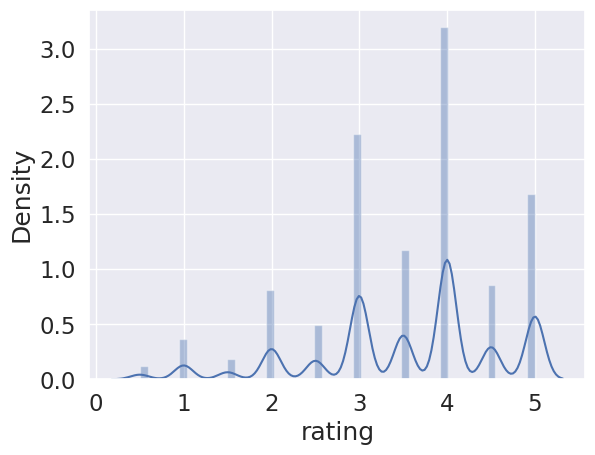

In [79]:
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

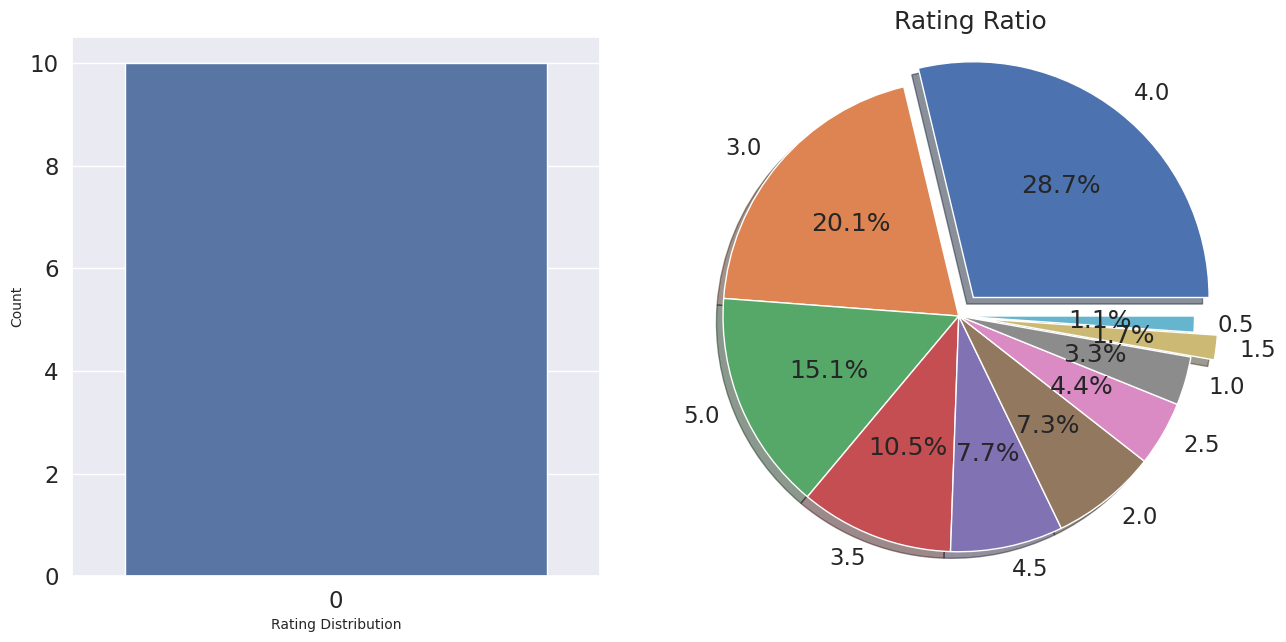

In [80]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.countplot(rating_counts['Ratings'], ax=ax1)
ax1.set_xlabel('Rating Distribution', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)

explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0.1, 0)
ax2.pie(rating_counts["Ratings"], explode=explode, labels=rating_counts.Labels, autopct='%1.1f%%', shadow=True, startangle=0)
ax2.axis('equal')
plt.title("Rating Ratio")
plt.show()

In [81]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'],cv=5)

{'test_rmse': array([0.8936342 , 0.89594404, 0.89066005, 0.90328678, 0.89756443]),
 'test_mae': array([0.68748725, 0.69021662, 0.68587174, 0.69786938, 0.69004123]),
 'fit_time': (1.3685989379882812,
  1.3688199520111084,
  1.3664319515228271,
  1.3694164752960205,
  1.4009063243865967),
 'test_time': (0.22973227500915527,
  0.1487433910369873,
  0.36304473876953125,
  0.13553118705749512,
  0.1590254306793213)}

We get a mean Root Mean Sqaure Error of 0.8944 which is more than good enough for our case. Let us now train on our dataset and arrive at predictions.

In [82]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [83]:
user_rating=pd.merge(ratings,meta,left_on='movieId',right_on='id',how='inner')
user_ratings_final=user_rating[['userId', 'movieId', 'rating','original_title']]
user_ratings=user_ratings_final.sort_values(by='userId')
user_ratings.head()

,userId,movieId,rating,original_title
0,1,1371,2.5,Rocky III
93,1,2105,4.0,American Pie
140,1,2193,2.0,My Tutor
47,1,1405,1.0,Greed
182,1,2294,2.0,Jay and Silent Bob Strike Back


Now we shall be checking for a particular user- as to what are the ratings he/she has given to the movies watched. Based on that we shall be trying to predict what will be the rating he/she shall give to a new movie.

Let us choose User no. 7. First lets take a look into the movies he/she has watched.

In [84]:
user_ratings[user_ratings['userId'] == 7]

,userId,movieId,rating,original_title
18645,7,671,4.0,Harry Potter and the Philosopher's Stone
4200,7,500,3.0,Reservoir Dogs
18739,7,745,5.0,The Sixth Sense
18801,7,780,3.0,La passion de Jeanne d'Arc
11487,7,1376,3.0,Sweet Sixteen
48,7,1405,5.0,Greed
8557,7,260,5.0,The 39 Steps
4770,7,539,3.0,Psycho
3242,7,377,3.0,A Nightmare on Elm Street
19019,7,786,2.0,Almost Famous


**Observations** Okay what we see is, the user here has seen multiple movies from the action and horror genres. So in order to test on this particular user, let us choose two movies that he/she did not watch- and accordingly shall predict his/her ratings for the same.

Lets Choose a movie:

1. Since he has watched multiple horror movies- will give him a horror movie to estimate his ratings. Our choice: The Conjuring

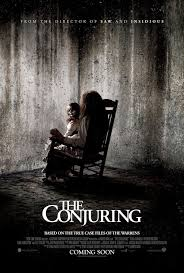

First, lets identify the Movie Id for this movie...

In [85]:
movie1=meta['original_title']=='The Conjuring'
meta[movie1][['original_title','id']]

,original_title,id
21475,The Conjuring,138843


So, lets see how much will the user like the movie "The Conjuring"

In [86]:
svd.predict(7, 138843, 3)

Prediction(uid=7, iid=138843, r_ui=3, est=3.2698423862139467, details={'was_impossible': False})

**Observations** Okay, 3.33 is a mediocre rating.But if we check the movies listed above, he/she has mostly rated them a 3- so in that order, a 3.27 seems better than those.

# A Hybrid Recommender

In this section, we will try to build a movie recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:

For this we shall be creating a function recommend_my_movie()- which will be responsible to provide out the recommendation list

**Input:**
User ID and the Title of a Movie

**Output:**
Similar movies sorted on the basis of expected ratings by that particular user.

In [87]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [88]:
id_map = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')

In [89]:
indices_map = id_map.set_index('id')

In [90]:
def recommend_my_movie(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

Let's check for the 7th User we had just seen above!

In [91]:
recommend_my_movie(7, "Inception")

,title,vote_count,vote_average,year,id,est
3381,Memento,4168.0,8.1,2000,77,4.311363
6623,The Prestige,4510.0,8.0,2006,1124,4.013988
6981,The Dark Knight,12269.0,8.3,2008,155,3.996582
8613,Interstellar,11187.0,8.1,2014,157336,3.862243
6218,Batman Begins,7511.0,7.5,2005,272,3.683733
8031,The Dark Knight Rises,9263.0,7.6,2012,49026,3.647513
4173,Minority Report,2663.0,7.1,2002,180,3.496177
6640,Déjà Vu,1519.0,6.6,2006,7551,3.437623
7948,Stake Land,290.0,6.2,2010,52015,3.329964
8207,Looper,4777.0,6.6,2012,59967,3.329666


In [93]:
cross_validate(recommend_my_movie, data, measures=['RMSE', 'MAE'],cv=5)

AttributeError: ignored

Now, just for the sake of comparing- we are choosing a different user. But trying to get the recommendations on the same movie.

Lets just choose user 25 for our reference!

In [ ]:
recommend_my_movie(25, "Inception")

We see that for our hybrid recommender, we get different recommendations for different users although the movie is the same. Hence, our recommendations are more personalized and tailored towards particular users.

# Conclusions

In this notebook, we have built 4 different recommendation engines based on different ideas and algorithms. They are as follows:

1. **Simple Recommender**: This system used overall TMDB Vote Count and Vote Averages to build Top Movies Charts, in general and for a specific genre. The IMDB Weighted Rating System was used to calculate ratings on which the sorting was finally performed.

2. **Content Based Recommender**: We built two content based engines; one that took movie overview and taglines as input and the other which took metadata such as cast, crew, genre and keywords to come up with predictions. We also deviced a simple filter to give greater preference to movies with more votes and higher ratings.

3. **Collaborative Filtering Approach**: We used the powerful Surprise Library to build a collaborative filter based on single value decomposition. The RMSE obtained was less than 1 and the engine gave estimated ratings for a given user and movie.

4. **Combined Recommendation Engine**: We brought together ideas from content and collaborative filterting to build an engine that gave movie suggestions to a particular user based on the estimated ratings that it had internally calculated for that user.

Overall the data source is very well oriented, and not much of a cleaning task was required. Will be adding on many more updates!!!
